In [27]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
rng = np.random
from array import array
from scipy import stats

#Keras import 
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import *

#import models
from Linear_Regression import linear_regression

#import datetime for tensorboard
from datetime import *

In [28]:
# data import from matlab
subject_1 = sio.loadmat('1.mat')      #recovering matlab data in the form of a python dictionar
format_1 = subject_1['data']          #in the dictionary, only the data key interests us
print (format_1.shape)

# shuffle trials
(channel, trial, time_points)= format_1.shape

trials = np.arange(trial)
np.random.shuffle(trials)

#Z score
format_1=stats.zscore(format_1, axis=2)

(65, 192, 1000)


In [30]:
# parametres

eltmp = input ('''Enter the electrode number:''')
electi = list(map(int, eltmp.split()))    #separation of the different responses and recovery in the form of a list of integers
print (type(electi))
print(electi)

stim = input ('''Enter the number of stimuli:''')
stim = int(stim)

relation = input('''Please define what should be predicted (1 for EEG or 2 for stimulus):''')

if relation == '1':
    source_Y = electi[0]    #retrieving the electrode number as a whole number - implies that there is only one electrode chosen in this direction
    source_X = [0]          #conversion of the stimuli line in the form of a list - necessary for the for loop: see below - extraction X

elif relation == '2':
    format_1 = np.flip(format_1,2)     # data inversion according to the time dimension - problem ????
    source_Y = 0
    source_X = electi

hiLaSi_tmp = input('''please specify the number of layers and neurons per desired layers: ''')
hidden_layers_size = list(map(int, hiLaSi_tmp.split()))
print (hidden_layers_size)
print (type(hidden_layers_size))

learning_rate = input('''enter the lambda / learning rate: ''')
learning_rate = float(learning_rate)      # conversion as a decimal number

Enter the electrode number:30
<class 'list'>
[30]
Enter the number of stimuli:160
Please define what should be predicted (1 for EEG or 2 for stimulus):1
please specify the number of layers and neurons per desired layers: 1
[1]
<class 'list'>
enter the lambda / learning rate: 0.1


In [31]:
#### separation of train tests / valid / test

train_num = int(np.around(len(trials) * 0.8))
valid_num = int(np.around(len(trials) * 0.1))
test_num = len(trials) - train_num - valid_num

trials_train = trials[0:train_num]
trials_valid = trials[train_num:train_num+valid_num]
trials_test = trials[train_num+valid_num:]

In [32]:
# extract data from format_1

def extract_Y (batch_trials, batch_num):              #creation of a function to recover y - simplification of reading
    
    y_tmp=format_1[source_Y, batch_trials, stim:]     #recovery of Y in the form of a matrix of 154 * 840
    y_tmp=np.reshape(y_tmp, ((time_points-stim)*batch_num))    #passage through the list of 129 360 values ​​(test 0, test 1, ... test 153)
    y_tmp=np.matrix(y_tmp)                           #1 * 129360 matrix conversion
    y_tmp=np.transpose(y_tmp)                        #transposition into a matrix of 129360 * 1, matrix equal to that of Matlab (necessary for the rest)
    return y_tmp                                     #returns the content of y_tmp
    
y_train = extract_Y (trials_train, train_num)
print ("y_train.shape = ", y_train.shape)
y_valid = extract_Y (trials_valid, valid_num)
print ("y_valid.shape = ", y_valid.shape)
y_test = extract_Y (trials_test, test_num)
print ("y_test.shape = ", y_test.shape)

y_train.shape =  (129360, 1)
y_valid.shape =  (15960, 1)
y_test.shape =  (15960, 1)


In [33]:
def extract_X (batch_trials, batch_num):                     #creation of a function to recover x - simplification of reading
    x_tmp = [[]]*((time_points-stim)*batch_num)                       #creation of an empty list x_tmp of size (129630,)
    x_tmp = np.matrix(x_tmp)                                #conversion as a matrix 129630 * 0 (number of lines good)
    x_tmp = np.transpose(x_tmp)                             #transposition 1: form 0 * 129630, necessary at n.append
                                                            #avoid the transposition line in the for loop (2 transpo instead of 160
    for i in source_X:                                      #reading the source list -> reading each electrode number if flip
        k = 0
        while k < stim:                                     #160 loops - recovery of the 840 values ​​of each test (in the form test 1, test 2, ...), shifted by 1 at each iteration
            tmp = format_1[i, batch_trials, k:(time_points-stim+k)]    #see extract_Y
            tmp = np.reshape(tmp,((time_points-stim)*batch_num))
            tmp = np.matrix(tmp)
            
            x_tmp = np.append(x_tmp, tmp, axis=0)           #concatenation of the matrix tmp 1 * 129360 at the end of the matrix x_tmp (k + 1) * 129360
            k = k+1
    x_tmp = np.transpose(x_tmp)                             #transposition 2: form 129360 * (160 * nbr_électrode)
    return x_tmp
        
x_train = extract_X (trials_train, train_num)
print ("x_train.shape = ", x_train.shape)
x_valid = extract_X (trials_valid, valid_num)
print ("x_valid.shape = ", x_valid.shape)
x_test = extract_X (trials_test, test_num)
print ("x_test.shape = ", x_test.shape)

x_train.shape =  (129360, 160)
x_valid.shape =  (15960, 160)
x_test.shape =  (15960, 160)


In [34]:
#tensorflow - Linear regression cf github

training_epochs = 200
display_step = 10

train_X = x_train
print(train_X.shape)
train_Y = y_train
print(train_Y.shape)
n_samples_train = train_X.shape[0]

valid_X = x_valid
valid_Y = y_valid
n_samples_valid = valid_X.shape[0]

test_X = x_test
test_Y = y_test
n_samples_test = test_X.shape[0]

(129360, 160)
(129360, 1)


In [35]:
#Define Keras Model 
model = linear_regression(train_X.shape[1])


In [36]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 161       
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [40]:
#Set Up Tensorboard for visualisation for training
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)


logs/scalars/20200115-163712


In [16]:
#Define training Loss 
def mse(y_true, y_pred):
    return (K.mean(K.square(y_pred - y_true), axis=-1)) / 2

In [43]:
#Set up the Optimizers
sgd = optimizers.SGD(lr = learning_rate)
adam = optimizers.Adam(lr = learning_rate)
rmsprop = optimizers.RMSprop(lr = learning_rate)

#Compile the model
model.compile(loss = mse, optimizer = sgd , metrics=[mse])

In [ ]:
#Fit the model with the Data
model.fit(
    train_X, 
    train_Y, 
    epochs = training_epochs, 
    validation_data = (valid_X, valid_Y), 
    verbose = 1,
    callbacks = [tensorboard_callback])

Train on 129360 samples, validate on 15960 samples
Epoch 1/200
129360/129360 [==============================] - 7s 52us/step - loss: 0.6410 - mse: 0.6410 - val_loss: 0.6323 - val_mse: 0.6323
Epoch 2/200
129360/129360 [==============================] - 7s 54us/step - loss: 0.6421 - mse: 0.6421 - val_loss: 0.6922 - val_mse: 0.6922
Epoch 3/200
129360/129360 [==============================] - 7s 52us/step - loss: 0.6430 - mse: 0.6430 - val_loss: 0.6526 - val_mse: 0.6526
Epoch 4/200
129360/129360 [==============================] - 7s 53us/step - loss: 0.6441 - mse: 0.6441 - val_loss: 0.6366 - val_mse: 0.6366
Epoch 5/200
129360/129360 [==============================] - 7s 53us/step - loss: 0.6423 - mse: 0.6423 - val_loss: 0.6429 - val_mse: 0.6429
Epoch 6/200
129360/129360 [==============================] - 7s 54us/step - loss: 0.6414 - mse: 0.6414 - val_loss: 0.6559 - val_mse: 0.6559
Epoch 7/200
129360/129360 [==============================] - 7s 53us/step - loss: 0.6419 - mse: 0.6419 - val_

Epoch 59/200
129360/129360 [==============================] - 7s 52us/step - loss: 0.6433 - mse: 0.6433 - val_loss: 0.6175 - val_mse: 0.6175
Epoch 60/200
129360/129360 [==============================] - 7s 53us/step - loss: 0.6433 - mse: 0.6433 - val_loss: 0.6779 - val_mse: 0.6779
Epoch 61/200
129360/129360 [==============================] - 7s 53us/step - loss: 0.6448 - mse: 0.6448 - val_loss: 0.6624 - val_mse: 0.6624
Epoch 62/200
129360/129360 [==============================] - 7s 53us/step - loss: 0.6434 - mse: 0.6434 - val_loss: 0.7177 - val_mse: 0.7177
Epoch 63/200
129360/129360 [==============================] - 7s 52us/step - loss: 0.6412 - mse: 0.6412 - val_loss: 0.6852 - val_mse: 0.6852
Epoch 64/200
129360/129360 [==============================] - 7s 53us/step - loss: 0.6407 - mse: 0.6407 - val_loss: 0.6920 - val_mse: 0.6920
Epoch 65/200
129360/129360 [==============================] - 7s 54us/step - loss: 0.6421 - mse: 0.6421 - val_loss: 0.6417 - val_mse: 0.6417
Epoch 66/200


In [21]:
score = model.evaluate(test_X, test_Y)
print("Test Loss:", score[0])


15960/15960 [==============================] - 0s 21us/step
Test Loss: 2.4694464987083187


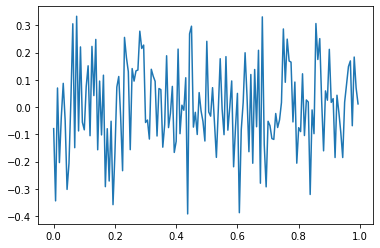

In [20]:
weights = model.get_weights() #Extract the weight sof the model
T = np.arange(0, 0.00625*stim, 0.00625) #Time interval of 1 sec containing stimuli points 
plt.plot(T, weights[0])

In [ ]:
    # tf Graph Input
(size_L, size_C) = train_X.shape
X = tf.placeholder("float", [None,size_C])
Y = tf.placeholder("float",[None,1])

W={}   #creation of a dictionary W, each key of the dictionary will contain the weights of a layer
bb={}    #same for baby

    # Set model weights
hidden_layers_size = [size_C]+hidden_layers_size    #we add the number of columns of the base matrix (ex: 160) to the list of layers
print(hidden_layers_size)                           # ex : 160 2 3 1

for i,j in enumerate(hidden_layers_size[:-1]):
        W_tmp = tf.Variable(tf.fill([j,hidden_layers_size[i+1]],rng.randn()))  # For each index i having the value j excluding the last layer (ex: 0: 160, 1: 2, 2: 3)
        W[i+1] = W_tmp   #we create a tensorflow variable W having for size (layer * next_layer) #ex: 3 layers W: 160 * 2, 2 * 3, 3 * 1
    
        bb_tmp = tf.Variable(tf.fill([hidden_layers_size[i+1]],rng.randn()))   #we create a tensorflow variable W having for size (next_layer)
        bb[i+1] = bb_tmp    #we add a new key to the dictionary, containing the new layer (key index: 1 2 3 ... to change according to preference)

In [ ]:
print (X.shape)
print (W)
print (bb)

In [ ]:
 # Construct a linear model
#hiddenX = tf.nn.xw_plus_b(X,W1,bb1)
#pred = tf.nn.xw_plus_b(hiddenX,W2,bb2)

hidden_X_tmp = X  #corresponds to the data that we enter (extract_X)
hidden_X = {}      #similar to W: creation of a dictionary storing the hidden_X of the different layers
i = 1

while i <= len(W):
    hidden_X_tmp = tf.nn.xw_plus_b(hidden_X_tmp,W[i],bb[i])   #2 times the same values ​​for two neurons of the same layer ... the problem may come from here
    hidden_X[i] = hidden_X_tmp
    i=i+1

print (hidden_X)
pred = hidden_X[len(W)]     #pred corresponds to the hidden_X of the last layer - review the indexing?
print (pred)

In [ ]:
    # Mean squared error
cost_train = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples_train)
cost_valid = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples_valid)
cost_test = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*n_samples_test)
    # Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_train)

In [ ]:
# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
   # Fit all training data
    for epoch in range(training_epochs):
        sess.run(optimizer, feed_dict={X: train_X, Y: train_Y})

        #Display logs per epoch step
        if (epoch+1) % display_step == 0:
            cost = sess.run(cost_train, feed_dict={X: train_X, Y:train_Y})
            print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(cost))
            costV = sess.run(cost_valid, feed_dict={X: valid_X, Y: valid_Y})
            print ("Epoch:", '%04d' % (epoch+1), "valid_cost=", "{:.9f}".format(costV))

    print ("Optimization Finished!")
    training_cost = sess.run(cost_train, feed_dict={X: train_X, Y: train_Y})
    print ("training_cost = ", training_cost) 
    test_cost = sess.run(cost_test, feed_dict={X: test_X, Y: test_Y})
    print ("test_cost = ", test_cost)
    
       #Graphic display
        
    T = np.arange(0, 0.00625*stim, 0.00625)                       # creation of the time variable (on 1s) for the abscissa
    
    nbr_elct = len(electi)
    (Lo_W, la_W) = W[1].shape
    Lo_W = int(Lo_W)                                              # number of lines: inputs (160 * nbr_electrodes, for example)
    la_W = int(la_W)                                              # number of columns: number of neurons in the layer
    
    z=0
    while z < nbr_elct:                                           # for each electrode
        z_1=0 
        while z_1 < la_W:                                         # for each neuron of the W layer [1]
            W_tmp = tf.slice(W[1], [0, z_1], [Lo_W, 1])           # slice: starting value [line 0, column of the neuron], dimensions of the section [160 * nbr_electrodes lines, 1 column])
            W_tmp = tf.slice(W_tmp, [z*stim, 0], [stim, 1])       # slice: starting value [first value of the new electrode, column 0], dimensions of the section [160 lines, 1 column]
            print (W_tmp.shape)
            
            plt.plot(T, sess.run(W_tmp), label= ("neurone_", z_1, "layer_1, electrode_", electi[z]))
            z_1 = z_1+1
            
        z = z+1
        
    plt.legend()    
    plt.show()
    #plt.close()   

In [ ]:
print(len(T))